# Create an Anomaly Detection Workflow

In [8]:
# Import to be able to import python package from src
import sys
sys.path.insert(0, '../src')

In [9]:
import pandas as pd
import numpy as np
import ontime as on
from IPython.display import Image

## Prerequisite

Install Prefect within your project

In [10]:
!pip install prefect


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


---
## Generation of random time series

In [11]:
ts = on.generators.random_walk().generate(start=pd.Timestamp('2022-01-01'), end=pd.Timestamp('2022-12-31'))

## Create a Prefect Flow and Tasks

In [12]:
from prefect import task, flow, get_run_logger
from ontime.context import common

@task
def task_detect(ts):
    det = on.detectors.quantile(low_quantile=0.1, high_quantile=0.9)
    det.fit(ts)
    return det.detect(ts)

@task
def task_predict(ts):
    model = common.GenericPredictor()
    model.fit(ts)
    return model.predict(48)

@flow
def detection_flow(ts, log_prints=True):
    ts_ano = task_detect(ts)
    ts_pred = task_predict(ts)
    ts_pred_ano = task_detect(ts_pred)
    return ts_ano, ts_pred, ts_pred_ano

## Display the graph

/home/benjy/.cache/pypoetry/virtualenvs/ontime-2OQVvbNf-py3.10/lib/python3.10/site-packages/prefect/flows.py:1374: UserWarning: `flow.visualize()` will execute code inside of your flow that is not decorated with `@task` or `@flow`.
  warnings.warn(


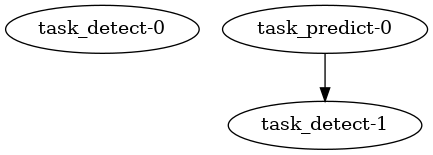

Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
No applications found for mimetype: image/png
./usr/bin/xdg-open: 882: x-www-browser: not found
/usr/bin/xdg-open: 882: firefox: not found
/usr/bin/xdg-open: 882: iceweasel: not found
/usr/bin/xdg-open: 882: seamonkey: not found
/usr/bin/xdg-open: 882: mozilla: not found
/usr/bin/xdg-open: 882: epiphany: not found
/usr/bin/xdg-open: 882: konqueror: not found
/usr/bin/xdg-open: 882: chromium: not found
/usr/bin/xdg-open: 882: chromium-browser: not found
/usr/bin/xdg-open: 882: google-chrome: not found
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method avai

In [13]:
res = await detection_flow.visualize(ts)
Image(filename=f'./{detection_flow.name}.png')

## Run the flow

In [14]:
ts_ano, ts_pred, ts_pred_ano = detection_flow(ts)

10:05:21.293 | INFO    | Flow run 'tangible-elephant' - Beginning flow run 'tangible-elephant' for flow 'detection-flow'

10:05:21.381 | INFO    | Task run 'task_detect-48e' - Finished in state Completed()

10:05:22.481 | INFO    | Task run 'task_predict-70b' - Finished in state Completed()

10:05:22.556 | INFO    | Task run 'task_detect-33f' - Finished in state Completed()

10:05:22.611 | INFO    | Flow run 'tangible-elephant' - Finished in state Completed()

## Show results

In [18]:
(
    on.Plot()
    .add(on.marks.line, ts.rename({"random_walk": "truth"}))
    .add(on.marks.line, ts_ano.rename({"random_walk": "anomalies"}))
    .add(on.marks.line, ts_pred.rename({"random_walk": "predictions"}))
    .add(on.marks.line, ts_pred_ano.rename({"random_walk": "predicted anomalies"}))
    .properties(width=500)
    .show()
)

alt.LayerChart(...)